In [6]:
import os
import pandas as pd
from collections import defaultdict
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
ROOT_DIR = '/content/drive/MyDrive/Motmaen/food photos'
SPLIT_FOLDERS = ['train', 'valid', 'test']
class_names = ['Fattah','Fool','Hawawshy','Koshari','Kunafa','Mahshy El Kosa','Ptata','Taameya','Umm Ali']

In [3]:
data_counts = defaultdict(lambda: {split: 0 for split in SPLIT_FOLDERS})
try:
    for split in SPLIT_FOLDERS:
        split_path = os.path.join(ROOT_DIR, split)
        if not os.path.isdir(split_path):
            print(f"Warning: {split_path}")
            continue
        for class_name in class_names:
            class_path = os.path.join(split_path, class_name)
            count = len([name for name in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, name))])
            data_counts[class_name][split] = count
except Exception as e:
    print(f"error in file {e}")

df_counts = pd.DataFrame(data_counts).T
df_counts = df_counts.sort_index()
df_counts['Total'] = df_counts.sum(axis=1)
df_counts.loc['Total'] = df_counts.sum()
print("-" * 70)
print(df_counts)

----------------------------------------------------------------------
                train  valid  test  Total
Fattah             54     16    14     84
Fool               47     15    13     75
Hawawshy           56     17    13     86
Koshari            61     19    15     95
Kunafa             52     10    10     72
Mahshy El Kosa     52     16    11     79
Ptata              64     19    14     97
Taameya            57     19    15     91
Umm Ali            59     16    12     87
Total             502    147   117    766


In [5]:
ROOT_DIR = '/content/drive/MyDrive/Motmaen/food photos'
TARGET_COUNTS = {
    'train': 70,
    'valid': 20,
    'test': 15
}

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

def targeted_augmentation():
    for split, target_count in TARGET_COUNTS.items():
        split_path = os.path.join(ROOT_DIR, split)
        #To ensure no errors in reading data
        if not os.path.isdir(split_path):
            print(f"Undefined Path: {split_path}")
            continue
        print(f"\n Image Group {split.upper()}, Target {target_count}")
        for class_name in class_names:
            class_path = os.path.join(split_path, class_name)
            current_count = len([name for name in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, name))])
            images_to_generate = target_count - current_count
            if images_to_generate > 0:
                generator = datagen.flow_from_directory(
                    os.path.dirname(class_path),
                    classes=[class_name],
                    target_size=(224, 224),
                    batch_size=1,
                    save_to_dir=class_path,
                    save_prefix='aug',
                    save_format='jpeg',
                    shuffle=False
                )
                steps_needed = images_to_generate
                for i in range(steps_needed):
                    next(generator)
                print(f"   [ {class_name} ]: Generate: {images_to_generate}, Count: {target_count}.")
            else:
                print(f"   [ {class_name} ]: Current: ({current_count}) Can not generate.")

targeted_augmentation()


 Image Group TRAIN, Target 70
Found 54 images belonging to 1 classes.
   [ Fattah ]: Generate: 16, Count: 70.
Found 47 images belonging to 1 classes.
   [ Fool ]: Generate: 23, Count: 70.
Found 56 images belonging to 1 classes.
   [ Hawawshy ]: Generate: 14, Count: 70.
Found 61 images belonging to 1 classes.
   [ Koshari ]: Generate: 9, Count: 70.
Found 52 images belonging to 1 classes.
   [ Kunafa ]: Generate: 18, Count: 70.
Found 52 images belonging to 1 classes.
   [ Mahshy El Kosa ]: Generate: 18, Count: 70.
Found 64 images belonging to 1 classes.
   [ Ptata ]: Generate: 6, Count: 70.
Found 57 images belonging to 1 classes.
   [ Taameya ]: Generate: 13, Count: 70.
Found 59 images belonging to 1 classes.
   [ Umm Ali ]: Generate: 11, Count: 70.

 Image Group VALID, Target 20
Found 16 images belonging to 1 classes.
   [ Fattah ]: Generate: 4, Count: 20.
Found 15 images belonging to 1 classes.
   [ Fool ]: Generate: 5, Count: 20.
Found 17 images belonging to 1 classes.
   [ Hawawshy 

Sample Taked 495


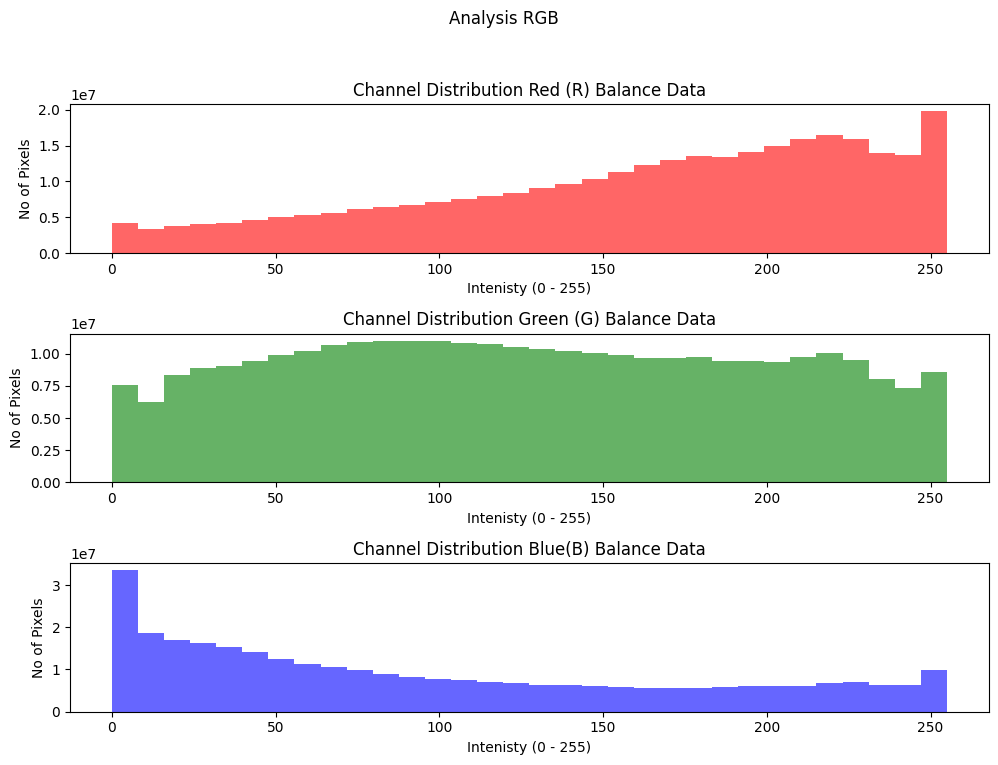

In [8]:
sampled_paths = []
all_class_names = []
N_PER_CLASS=20
for split in SPLIT_FOLDERS:
    split_path = os.path.join(ROOT_DIR, split)
    if os.path.isdir(split_path):
        if not all_class_names:
             all_class_names = [d for d in os.listdir(split_path)
                                if os.path.isdir(os.path.join(split_path, d))]

        for cls in all_class_names:
            class_path = os.path.join(split_path, cls)
            if os.path.isdir(class_path):
                all_fns = [f for f in os.listdir(class_path)
                           if os.path.isfile(os.path.join(class_path, f))]
                chosen = random.sample(all_fns, min(N_PER_CLASS, len(all_fns))) if all_fns else []
                for fn in chosen:
                    sampled_paths.append((cls, os.path.join(class_path, fn)))

print(f"Sample Taked {len(sampled_paths)}")
#Histogram
bins = 32
fig, axs = plt.subplots(3, 1, figsize=(10, 8))
colors = ['r', 'g', 'b']
for i, c in enumerate(colors):
    channel_vals = []
    for cls, p in sampled_paths:
        try:
            img = np.array(Image.open(p).convert("RGB"))
            channel_vals.append(img[:, :, i].ravel())
        except Exception as e:
            print(f"Skip: {p} Error: {e}")
            continue
    if not channel_vals:
        continue
    all_vals = np.concatenate(channel_vals)
    axs[i].hist(all_vals, bins=bins, color=c, alpha=0.6)
    axs[i].set_title(f"Channel Distribution {['Red (R)', 'Green (G)', 'Blue(B)'][i]} Balance Data")
    axs[i].set_xlabel("Intenisty (0 - 255)")
    axs[i].set_ylabel("No of Pixels")

plt.suptitle("Analysis RGB")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

- Red Peak Between 200 and 240 -> brightness
- Green Peak Between 80 and 110 -> moderate
- Blue Peak between 0 and 10 -> Dark
- Red is most Dominance
- Blue is Deficiency
- The brightness range tell use :
    - The most of photos is warms
    - The problem is not with the general lighting
    - With the color contrast and color range.
    - There is High Bias to Red Color
    - There is low Bias to Blue Color

In [7]:
# generate extra 15 photo in traning data colored corrected
EXTRA_AUGMENTATION_COUNT = 15
datagen_color_correction = ImageDataGenerator(
    channel_shift_range=70,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)
def final_disk_augmentation():
    split = 'train'
    split_path = os.path.join(ROOT_DIR, split)
    if not os.path.isdir(split_path):
        print(f"Path Not Exist {split_path} Stop")
        return
    print(f"\n Processing Group {split.upper()} (add {EXTRA_AUGMENTATION_COUNT} Corrected Photo to each Dish ---")

    for class_name in class_names:
        class_path = os.path.join(split_path, class_name)
        generator = datagen_color_correction.flow_from_directory(
            os.path.dirname(class_path),
            classes=[class_name],
            target_size=(224, 224),
            batch_size=1,
            save_to_dir=class_path,
            save_prefix=f'color_corr_{int(time.time())}_',
            save_format='jpeg',
            shuffle=True
        )
        steps_needed = EXTRA_AUGMENTATION_COUNT
        for i in range(steps_needed):
            next(generator)

        print(f"   [ {class_name} ]: Generate {steps_needed} additional corrected photo")
final_disk_augmentation()


 Processing Group TRAIN (add 15 Corrected Photo to each Dish ---
Found 70 images belonging to 1 classes.
   [ Fattah ]: Generate 15 additional corrected photo
Found 70 images belonging to 1 classes.
   [ Fool ]: Generate 15 additional corrected photo
Found 70 images belonging to 1 classes.
   [ Hawawshy ]: Generate 15 additional corrected photo
Found 70 images belonging to 1 classes.
   [ Koshari ]: Generate 15 additional corrected photo
Found 70 images belonging to 1 classes.
   [ Kunafa ]: Generate 15 additional corrected photo
Found 70 images belonging to 1 classes.
   [ Mahshy El Kosa ]: Generate 15 additional corrected photo
Found 70 images belonging to 1 classes.
   [ Ptata ]: Generate 15 additional corrected photo
Found 70 images belonging to 1 classes.
   [ Taameya ]: Generate 15 additional corrected photo
Found 70 images belonging to 1 classes.
   [ Umm Ali ]: Generate 15 additional corrected photo


In [9]:
data_counts = defaultdict(lambda: {split: 0 for split in SPLIT_FOLDERS})
try:
    for split in SPLIT_FOLDERS:
        split_path = os.path.join(ROOT_DIR, split)
        if not os.path.isdir(split_path):
            print(f"Warning: {split_path}")
            continue
        for class_name in class_names:
            class_path = os.path.join(split_path, class_name)
            count = len([name for name in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, name))])
            data_counts[class_name][split] = count
except Exception as e:
    print(f"error in file {e}")

df_counts = pd.DataFrame(data_counts).T
df_counts = df_counts.sort_index()
df_counts['Total'] = df_counts.sum(axis=1)
df_counts.loc['Total'] = df_counts.sum()
print("-" * 70)
print(df_counts)

----------------------------------------------------------------------
                train  valid  test  Total
Fattah             85     20    15    120
Fool               85     20    15    120
Hawawshy           85     20    15    120
Koshari            85     20    15    120
Kunafa             85     20    15    120
Mahshy El Kosa     85     20    15    120
Ptata              85     20    15    120
Taameya            85     20    15    120
Umm Ali            85     20    15    120
Total             765    180   135   1080
